In [1]:
import json
import os
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, pos_tag
import numpy as np
from PIL import Image
import clip
import torch

JSON_FILE = "/home/xinyi/volta/datasets/mscoco/dataset_coco.json"
IMAGE_DIR = "/home/xinyi/volta/datasets/mscoco/images"

with open(JSON_FILE, "r") as f:
    data = json.load(f)
items = data["images"]

In [2]:
# Tools
def isActionSentence(sent_tokens):
    sentence = pos_tag(sent_tokens)
    grammar = r'CHUNK: {<N.*>+<.*>?<V.*>+<.*>?<N.*>+}'
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(sentence)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK': 
            return True
    return False

def show_image(img_path):
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return image

def show_originals(index):
    item = items[index]
    img_path = os.path.join(IMAGE_DIR, item['filepath'],item['filename'])
    for sen in item['sentences']:
        print(sen['raw'])
    show_image(img_path)


def rank_captions(image, texts, model, preprocess, device):
    text_inputs = clip.tokenize(texts).to(device)
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Calculate features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = ( image_features @ text_features.T)

    # Rank k captions for image
    _, indices = similarity[0].topk(text_inputs.shape[0])
    rank = list(range(text_inputs.shape[0]))
    for i, value in enumerate(indices.to('cpu').numpy()):
        rank[value] = i+1 
    print(similarity.to('cpu').numpy())
    print(rank)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")
clip_model, clip_preprocess = clip.load('ViT-B/32', device)

device is cuda


# 1. Active/passive

In [4]:
img_list=[6, 5230, 87047,79198, 854, 6482,21309,21463,2793]
TEXT_FILE = "/home/xinyi/Language_Reasoning_Test/passive.txt"
with open(TEXT_FILE) as f:
    texts = f.read()
texts = texts.lower().split("\n")

## Original captions and images

6
A woman in a room with a cat.
A girl smiles as she holds a cat and wears a brightly colored skirt.
a woman is holding a cat in her kitchen
A woman is working in a kitchen carrying a soft toy.
A woman is holding a cat in her kitchen.


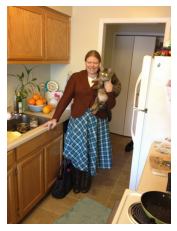

5230
Young girl with helmet on hold on tight to her father driving the motorcycle.
Girl holding onto Dad on the back of a motorcycle in traffic.
A man an a girl riding a motorcycle on a city street.
A man riding on the back of a motorcycle.
a close up of two people riding a motorcycle


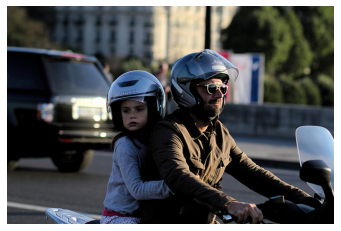

87047
A woman in a striped dress feeding an elephant.
an image of a woman feeding an elephant
A woman feeding an elephant by hand with a handler standing by.
A small crowd of people petting large elephants.
A girl on vacation feeding a large elephant.


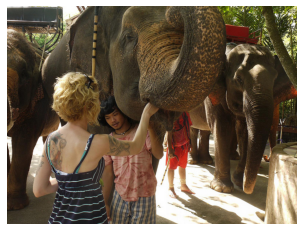

79198
A man holding a baby in a room.
The man is holding his baby while she brushes her teeth. 
Middle aged man in a white tee shirt holding a toddler
a man with eye glasses holding a small child
A man is glasses is holding a girl putting something in her mouth.


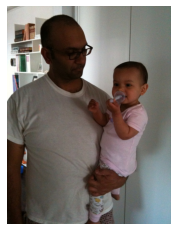

854
A dark skinned child getting ready to be pushed on a swing.
A girl getting pushed in a child's swing.
A man pushes a brightly smiling little girl on a swing.
a young girl on a swing being pushed by her dad
A man pushing a girl on a swing.


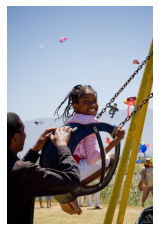

6482
A young man kissing the top of a young woman's head.
The young man is kissing the young woman on top of her head.
A man kisses the top of a woman's head.
The man kisses the girl on the head as she laughs.
A man is kissing a woman on the top of the head.


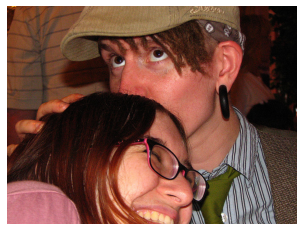

21309
A woman holding a child wrapped in a towel brushing her teeth.
A woman is holding a baby who is wrapped in a towel and holding a toothbrush
A woman holding a little boy who is brushing his teeth.
A baby with a toothbrush in his mouth while being held by a woman
a close up of an adult holding a child brushing their teeth


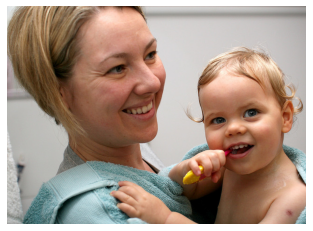

21463
A man sitting in a chair with a woman cutting his hair.
A woman gives a sitting man a haircut.
A man cutting another mans hair in a bathroom.
A man sits in a bathroom while a woman cuts his hair.
A woman is cutting a man's hair in a bathroom.


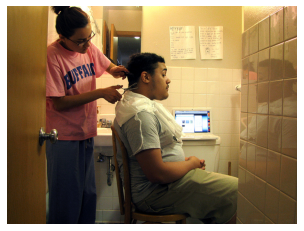

2793
A man standing next to a girl eating a piece of cake.
A bride and groom eating a piece of their wedding cake.
The bride is feeding the groom there wedding cake .
The couple is sharing a piece of cake while being photographed. 
A bride feeding the groom a piece of cake as a photographer takes a picture.


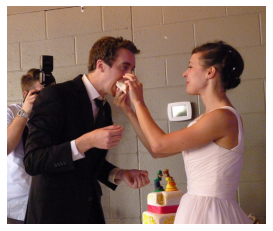

In [5]:
# show images and their original caption
for i, index in enumerate(img_list):
    print(index)
    show_originals(index)

## Constructed Sentences and CLIP results

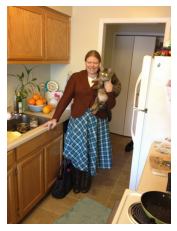

['a woman is holding a cat', 'a cat is being held by a woman', 'a cat is holding a woman', 'a woman is being held by a cat']
[[0.2622 0.257  0.259  0.2532]]
[1, 3, 2, 4]


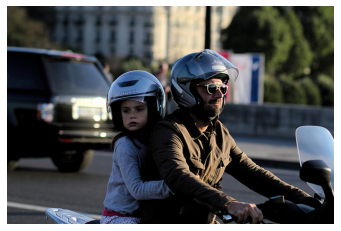

['a girl holds on tight to a man', 'a man is held on tight by a girl', 'a man holds on tight to a girl', 'a girl is held on tight by a man']
[[0.2363 0.2235 0.2367 0.2301]]
[2, 4, 1, 3]


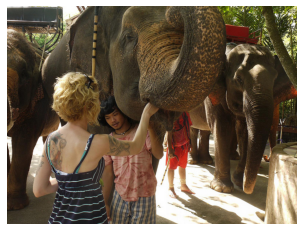

['a woman in a striped dress is feeding an elephant', 'an elephant is fed by a woman in a striped dress', 'an elephant is feeding a woman in a striped dress', 'a woman in a striped dress is fed by an elephant']
[[0.3142 0.309  0.307  0.3162]]
[2, 3, 4, 1]


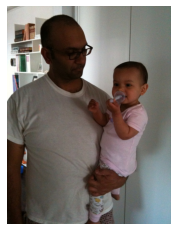

['a man is holding a baby', 'a baby is held by a man', 'a baby is holding a man', 'a man is held by a baby']
[[0.298  0.2856 0.289  0.287 ]]
[1, 4, 2, 3]


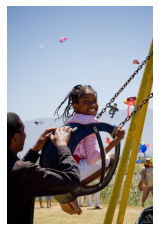

['a man is pushing a girl', 'a girl is pushd by a man', 'a girl is pushing a man', 'a man is pushd by a girl']
[[0.2349 0.1895 0.226  0.1849]]
[1, 3, 2, 4]


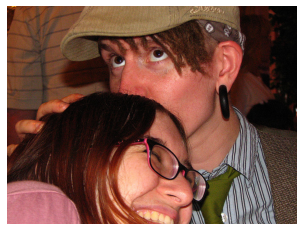

['a man is kissing a woman on the top of the head', 'a woman is kissed by a man on the top of the head', 'a woman is kissing a man on the top of the head', 'a man is kissed by a woman on the top of the head']
[[0.2727 0.276  0.2769 0.2742]]
[4, 2, 1, 3]


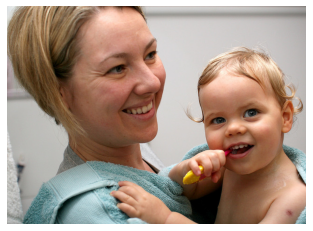

['a woman is holding a baby', 'a baby is held by a woman', 'a baby is holding a woman', 'a woman is held by a baby']
[[0.2747 0.2659 0.2722 0.2617]]
[1, 3, 2, 4]


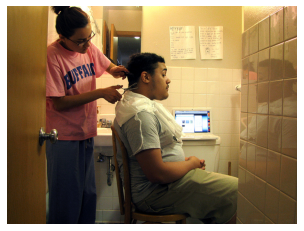

['a woman gives a man a haircut', 'a man is given a haircut by a woman', 'a man gives a woman a haircut', 'a woman is given a haircut by a man']
[[0.2773 0.2856 0.2708 0.283 ]]
[3, 1, 4, 2]


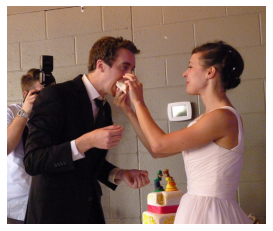

['the woman is feeding the man a piece of cake', 'the man is being fed a piece of cake by the woman', 'the man is feeding the woman a piece of cake', 'the woman is being fed a piece of cake by the man']
[[0.2976 0.2986 0.3025 0.2874]]
[3, 2, 1, 4]


In [6]:
for i, index in enumerate(img_list):
    item = items[index]
    img_path = os.path.join(IMAGE_DIR, item['filepath'],item['filename'])
    image = show_image(img_path)
    print(texts[i*4:(i+1)*4])
    rank_captions(image, texts[i*4:(i+1)*4], clip_model, clip_preprocess, device)

# 2. Relative Clause


79198


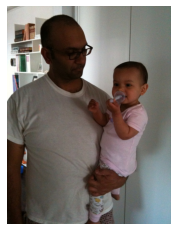

['a man who wears eye glasses is holding a small child', 'a man is holding a girl who is putting something in mouth', 'a man is holding a small child who wears eye glasses', 'a man who is putting something in mouth is holding a girl']
[[0.2815 0.2903 0.2952 0.2751]]
[3, 2, 1, 4]
5230


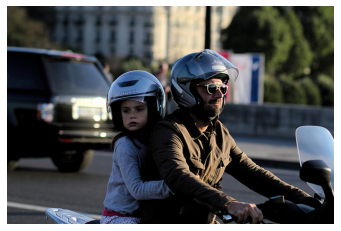

['a girl holds on tight to a man who is driving the motorcycle', 'a man who is driving the motorcycle is held on tight by a girl', 'a girl who is driving the motorcycle holds on tight to a man', 'a girl who is driving the motorcycle is held on tight by a man']
[[0.3208 0.3062 0.3157 0.3093]]
[1, 4, 2, 3]
37250


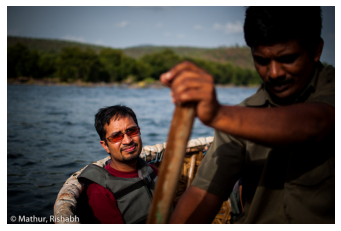

['a man who wears a life vest is looking on', 'a man who uses an oar is paddling a boat', 'a man who wears a life vest is paddling a boat', 'a man who uses an oar is looking on']
[[0.2524 0.2676 0.255  0.2876]]
[4, 2, 3, 1]
6482


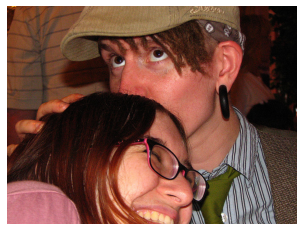

['a young man who wears a hat is kissing a young woman', 'a young man is kissing a young woman who is smiling', 'a young man is kissing a young woman who wears a hat', 'a young man who is smiling is kissing a young woman']
[[0.3047 0.288  0.3135 0.2827]]
[2, 3, 1, 4]
95726


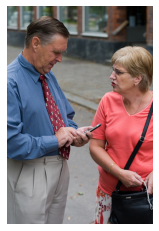

['a woman is talking to a man who is looking at the cell phone', 'a woman who wears a bag is talking to a man', 'a man is talking to a woman who is looking at the cell phone', 'a woman is talking to a man who wears a bag']
[[0.292  0.2466 0.2966 0.2659]]
[2, 4, 1, 3]


In [10]:
img_list = [79198,5230,37250,6482,95726]
TEXT_FILE = "/home/xinyi/Language_Reasoning_Test/relative_clause.txt"
with open(TEXT_FILE) as f:
    texts = f.read()
texts = texts.lower().split("\n")

for i, index in enumerate(img_list):
    print(index)
    item = items[index]
    img_path = os.path.join(IMAGE_DIR, item['filepath'],item['filename'])
    image = show_image(img_path)
    print(texts[i*4:(i+1)*4])
    rank_captions(image, texts[i*4:(i+1)*4], clip_model, clip_preprocess, device)